# Time-Series Forecasting of Carbon Monoxide and Nitrogen Dioxide Levels

Build predictive models to forecast daily or hourly concentrations of **CO(GT)** and **NO₂(GT)** based on historical data.


In [1]:
import pandas as pd

In [2]:
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
df = pd.read_csv(url)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [3]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

# Project Workflow

### **Deliverables**:
1. **Forecasting Models**:
   - Trained models for `CO(GT)` and `NO₂(GT)`.
2. **Forecast Visualization**:
   - Plots showing historical trends and future predictions.
3. **Evaluation Report**:
   - Metrics and comparison of different forecasting models.
4. **Insights and Recommendations**:
   - Suggestions for mitigating high levels of these gases based on predictions.


### 1. Data Preprocessing
- **Date-Time Parsing**:
  - Combine the `Date` and `Time` columns into a single `datetime` column.
  - Set the `datetime` column as the index of the dataset.
- **Resampling**:
  - Aggregate the data into meaningful time intervals (e.g., hourly or daily averages).
- **Handle Missing Values**:
  - Use interpolation, mean, or advanced imputation techniques to fill missing data for `CO(GT)` and `NO₂(GT)`.
- **Outlier Detection**:
  - Remove or cap extreme values in `CO(GT)` and `NO₂(GT)` using statistical thresholds.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Step 1: Load Dataset
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
try:
    data = pd.read_csv(url)
    print("Dataset Loaded Successfully!")
    print("Dataset Columns:", data.columns)
except Exception as e:
    print("Error loading dataset:", e)

# Step 2: Data Preprocessing
# Combine Date and Time columns into datetime and set as index
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
data.dropna(subset=['datetime'], inplace=True)
data.set_index('datetime', inplace=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)

# Resample to hourly averages
data_resampled = data.resample('H').mean()

# Handle missing values using interpolation
data_interpolated = data_resampled.interpolate(method='time')

# Outlier Detection and Removal
for col in ['CO(GT)', 'NO₂(GT)']:
    if col in data_interpolated.columns:
        q1 = data_interpolated[col].quantile(0.25)
        q3 = data_interpolated[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data_interpolated[col] = np.clip(data_interpolated[col], lower_bound, upper_bound)


Dataset Loaded Successfully!
Dataset Columns: Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')


C:\Users\alimd\AppData\Local\Temp\ipykernel_8440\1645788658.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample('H').mean()


### 2. Exploratory Data Analysis (EDA)
- **Trend Analysis**:
  - Visualize the long-term trends of `CO(GT)` and `NO₂(GT)`.
- **Seasonality**:
  - Identify seasonal patterns (e.g., daily or yearly fluctuations).
- **Correlation Analysis**:
  - Explore relationships between `CO(GT)`, `NO₂(GT)`, and other features (e.g., temperature or humidity).


Available features: Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')


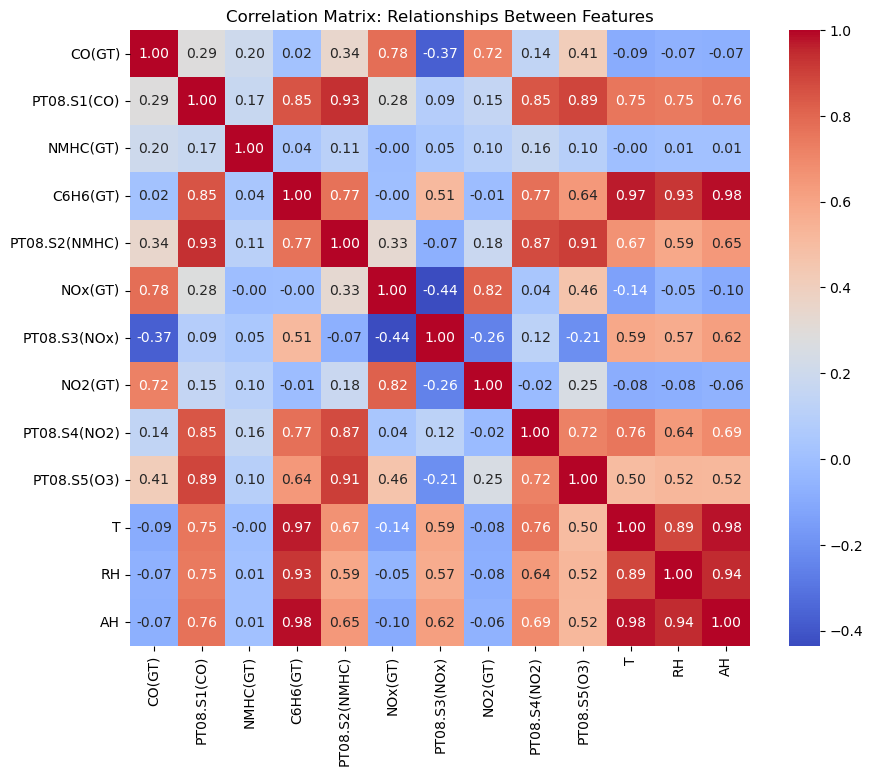

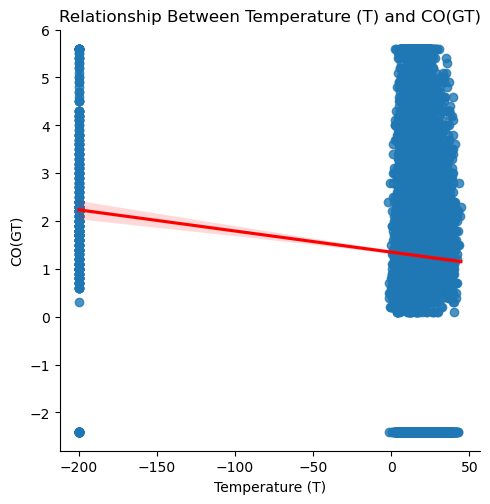

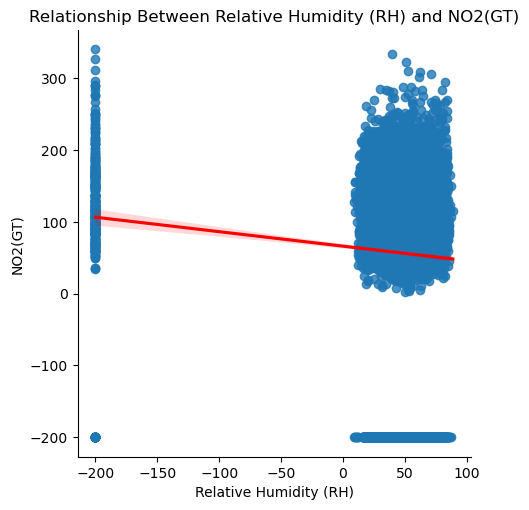

In [10]:
# Check available column names
print("Available features:", data_interpolated.columns)

# Plot the correlation matrix for all numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(data_interpolated.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix: Relationships Between Features')
plt.show()

# Focus on specific relationships using correct column names
sns.lmplot(x='T', y='CO(GT)', data=data_interpolated, line_kws={'color': 'red'})
plt.title('Relationship Between Temperature (T) and CO(GT)')
plt.xlabel('Temperature (T)')
plt.ylabel('CO(GT)')
plt.show()

sns.lmplot(x='RH', y='NO2(GT)', data=data_interpolated, line_kws={'color': 'red'})
plt.title('Relationship Between Relative Humidity (RH) and NO2(GT)')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('NO2(GT)')
plt.show()



### 3. Feature Engineering
- Create lag features for `CO(GT)` and `NO₂(GT)` to incorporate historical values.
- Add time-based features (e.g., hour of the day, day of the week, month).
- Include environmental factors (`T`, `RH`, `AH`) as predictors.


In [11]:
# Feature Engineering
# Create lag features for CO(GT) and NO₂(GT)
for col in ['CO(GT)', 'NO₂(GT)']:
    if col in data_interpolated.columns:
        for lag in range(1, 4):  # Create lag features for the last 3 hours
            data_interpolated[f'{col}_lag_{lag}'] = data_interpolated[col].shift(lag)

# Add time-based features
data_interpolated['hour'] = data_interpolated.index.hour
data_interpolated['day_of_week'] = data_interpolated.index.dayofweek  # Monday=0, Sunday=6
data_interpolated['month'] = data_interpolated.index.month

# Include environmental factors as predictors
# Make sure columns like 'T', 'RH', and 'AH' exist in the dataset
if 'T' in data_interpolated.columns:
    data_interpolated['T'] = data_interpolated['T']
if 'RH' in data_interpolated.columns:
    data_interpolated['RH'] = data_interpolated['RH']
if 'AH' in data_interpolated.columns:
    data_interpolated['AH'] = data_interpolated['AH']

# Check the new feature set
print("New feature set:")
print(data_interpolated.columns)

# Display a snapshot of the data
print(data_interpolated.head())


New feature set:
Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'CO(GT)_lag_1', 'CO(GT)_lag_2', 'CO(GT)_lag_3', 'hour',
       'day_of_week', 'month'],
      dtype='object')
                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
datetime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
datetime                                                            
2004-03-

### 4. Time-Series Forecasting
- Train separate models for **CO(GT)** and **NO₂(GT)**.
- Explore the following forecasting approaches:
  - **Statistical Models**:
    - Classical models like ARIMA or SARIMA for univariate forecasting.
  - **Machine Learning Models**:
    - Use regression models trained on lag features and external predictors.
  - **Deep Learning Models**:
    - Apply LSTM, GRU, or other RNN-based models for sequence forecasting.
- Evaluate and compare the models.


Dataset Loaded Successfully!
Dataset Columns: Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')


C:\Users\alimd\AppData\Local\Temp\ipykernel_8440\1162070830.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample('H').mean()


Forecasting results for CO(GT):
MAE: 3.2726930103077567
MSE: 13.568152450860918
RMSE: 3.6834973124546893


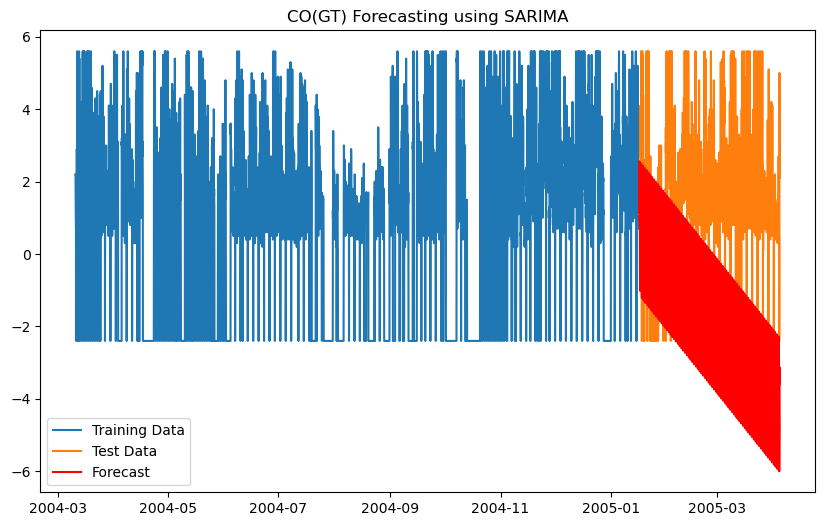

Forecasting results for NO2(GT):
MAE: 106.73674184361548
MSE: 14057.802470889024
RMSE: 118.56560408014217


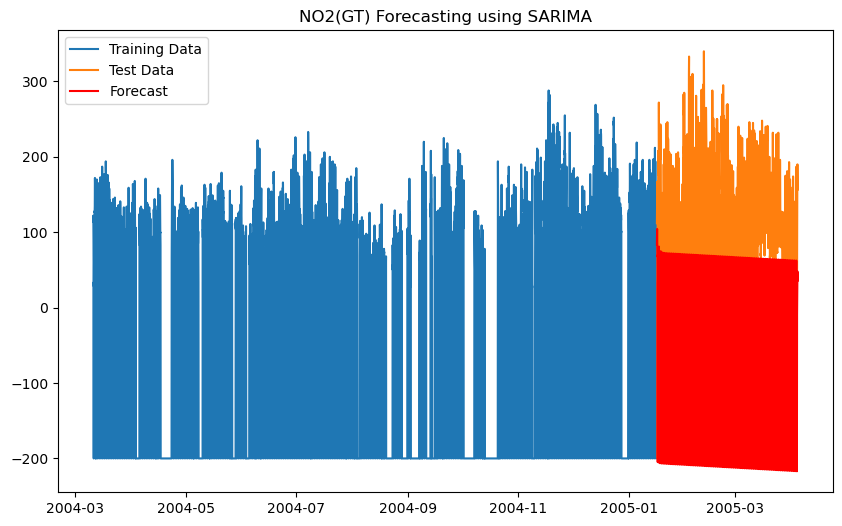

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Step 1: Load Dataset
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
try:
    data = pd.read_csv(url)
    print("Dataset Loaded Successfully!")
    print("Dataset Columns:", data.columns)
except Exception as e:
    print("Error loading dataset:", e)

# Step 2: Data Preprocessing
# Combine Date and Time columns into datetime and set as index
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
data.dropna(subset=['datetime'], inplace=True)
data.set_index('datetime', inplace=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)

# Resample to hourly averages
data_resampled = data.resample('H').mean()

# Handle missing values using interpolation
data_interpolated = data_resampled.interpolate(method='time')

# Outlier Detection and Removal
for col in ['CO(GT)', 'NO₂(GT)']:
    if col in data_interpolated.columns:
        q1 = data_interpolated[col].quantile(0.25)
        q3 = data_interpolated[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data_interpolated[col] = np.clip(data_interpolated[col], lower_bound, upper_bound)

# Ensure columns are correctly named
data_interpolated.rename(columns={'NO₂(GT)': 'NO2(GT)'}, inplace=True)

# Step 3: Feature Engineering
# Create lag features for CO(GT) and NO2(GT)
for col in ['CO(GT)', 'NO2(GT)']:
    data_interpolated[f'{col}_lag1'] = data_interpolated[col].shift(1)
    data_interpolated[f'{col}_lag2'] = data_interpolated[col].shift(2)

# Add time-based features
data_interpolated['hour'] = data_interpolated.index.hour
data_interpolated['day_of_week'] = data_interpolated.index.dayofweek
data_interpolated['month'] = data_interpolated.index.month

# Drop NaN values resulting from lag features
data_interpolated.dropna(inplace=True)

# Step 4: Time-Series Forecasting

# Define function to perform SARIMA forecasting
def sarima_forecast(data, target_column):
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    # Fit SARIMA model (Seasonal ARIMA)
    model = SARIMAX(train[target_column], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # Example SARIMA order
    results = model.fit(disp=False)

    # Forecast
    forecast = results.forecast(steps=len(test))

    # Evaluate the model
    mae = mean_absolute_error(test[target_column], forecast)
    mse = mean_squared_error(test[target_column], forecast)
    rmse = np.sqrt(mse)

    print(f"Forecasting results for {target_column}:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train[target_column], label='Training Data')
    plt.plot(test.index, test[target_column], label='Test Data')
    plt.plot(test.index, forecast, label='Forecast', color='red')
    plt.title(f'{target_column} Forecasting using SARIMA')
    plt.legend()
    plt.show()

# Forecast for CO(GT)
sarima_forecast(data_interpolated, 'CO(GT)')

# Forecast for NO2(GT)
sarima_forecast(data_interpolated, 'NO2(GT)')


Dataset Loaded Successfully!


C:\Users\alimd\AppData\Local\Temp\ipykernel_8440\210691856.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample('H').mean()


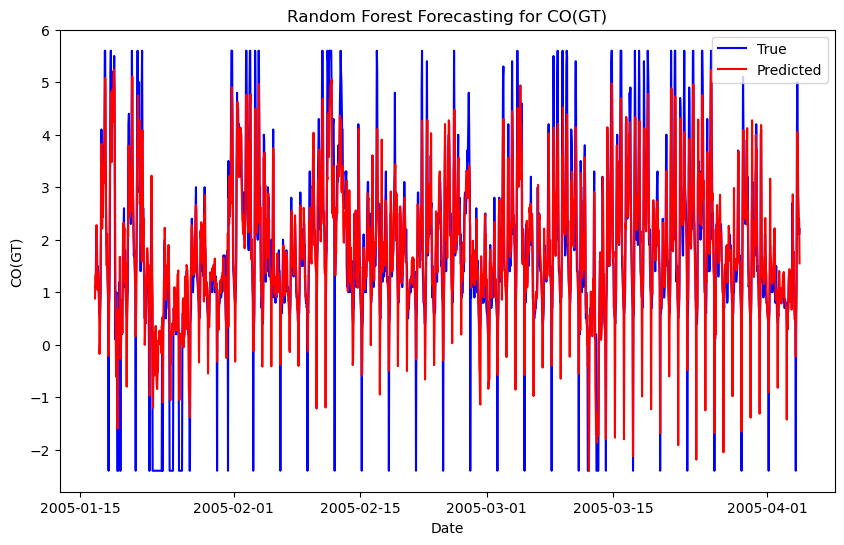

Mean Absolute Error (MAE) for CO(GT): 0.5281833244254409
Mean Squared Error (MSE) for CO(GT): 0.6366143041154461


In [17]:
#Machine Learning Model: Regression with Lag Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Load and preprocess dataset
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'

try:
    data = pd.read_csv(url)
    print("Dataset Loaded Successfully!")
except Exception as e:
    print("Error loading dataset:", e)

# Combine Date and Time columns into datetime and set as index
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
data.dropna(subset=['datetime'], inplace=True)
data.set_index('datetime', inplace=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)

# Resample data to hourly intervals and handle missing values
data_resampled = data.resample('H').mean()
data_interpolated = data_resampled.interpolate(method='time')

# Outlier detection and handling
for col in ['CO(GT)', 'NO₂(GT)']:
    if col in data_interpolated.columns:
        q1 = data_interpolated[col].quantile(0.25)
        q3 = data_interpolated[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data_interpolated[col] = np.clip(data_interpolated[col], lower_bound, upper_bound)

# Rename columns for consistency
data_interpolated.rename(columns={'NO₂(GT)': 'NO2(GT)'}, inplace=True)

# Step 2: Feature Engineering
# Create lag features
for lag in range(1, 4):
    data_interpolated[f'CO(GT)_lag_{lag}'] = data_interpolated['CO(GT)'].shift(lag)

# Add time-based features
data_interpolated['hour'] = data_interpolated.index.hour
data_interpolated['day_of_week'] = data_interpolated.index.dayofweek
data_interpolated['month'] = data_interpolated.index.month

# Drop rows with NaN values caused by lagging
data_interpolated.dropna(inplace=True)

# Step 3: Prepare data for regression
X = data_interpolated[['T', 'RH', 'AH', 'hour', 'day_of_week', 'month', 'CO(GT)_lag_1', 'CO(GT)_lag_2', 'CO(GT)_lag_3']]
y = data_interpolated['CO(GT)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.title('Random Forest Forecasting for CO(GT)')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

# Print evaluation metrics
print(f'Mean Absolute Error (MAE) for CO(GT): {mae}')
print(f'Mean Squared Error (MSE) for CO(GT): {mse}')


Epoch 1/20


C:\Users\alimd\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0699
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0187
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0171
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157
Epoch 12/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150
Epoch 13/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152
Epoch 14/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0160
Epoch 15/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143


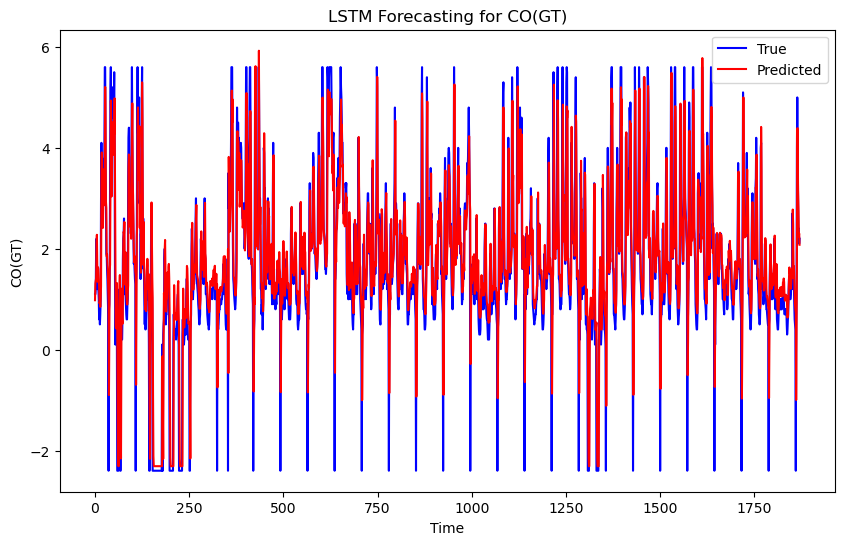

Mean Absolute Error (MAE) for CO(GT) with LSTM: 0.5703938566998467
Mean Squared Error (MSE) for CO(GT) with LSTM: 0.7444742401585636


In [19]:
#Deep Learning Model: LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Prepare the data for LSTM (scaling and reshaping)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_interpolated[['CO(GT)']].values)

# Create a function to generate sequences for LSTM
def create_sequences(data, time_steps=3):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences for CO(GT)
X, y = create_sequences(scaled_data)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae = mean_absolute_error(y_test_actual, predicted)
mse = mean_squared_error(y_test_actual, predicted)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='True', color='blue')
plt.plot(predicted, label='Predicted', color='red')
plt.title('LSTM Forecasting for CO(GT)')
plt.xlabel('Time')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()

print(f'Mean Absolute Error (MAE) for CO(GT) with LSTM: {mae}')
print(f'Mean Squared Error (MSE) for CO(GT) with LSTM: {mse}')


### 5. Model Evaluation
- Use appropriate metrics for forecasting:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Percentage Error (MAPE)
- Plot actual vs. predicted values to visualize performance.


Dataset Loaded Successfully!


C:\Users\alimd\AppData\Local\Temp\ipykernel_8440\1622035877.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_resampled = data.resample('H').mean()


Mean Absolute Error (MAE): 0.53
Root Mean Squared Error (RMSE): 0.80
Mean Absolute Percentage Error (MAPE): 42.53%


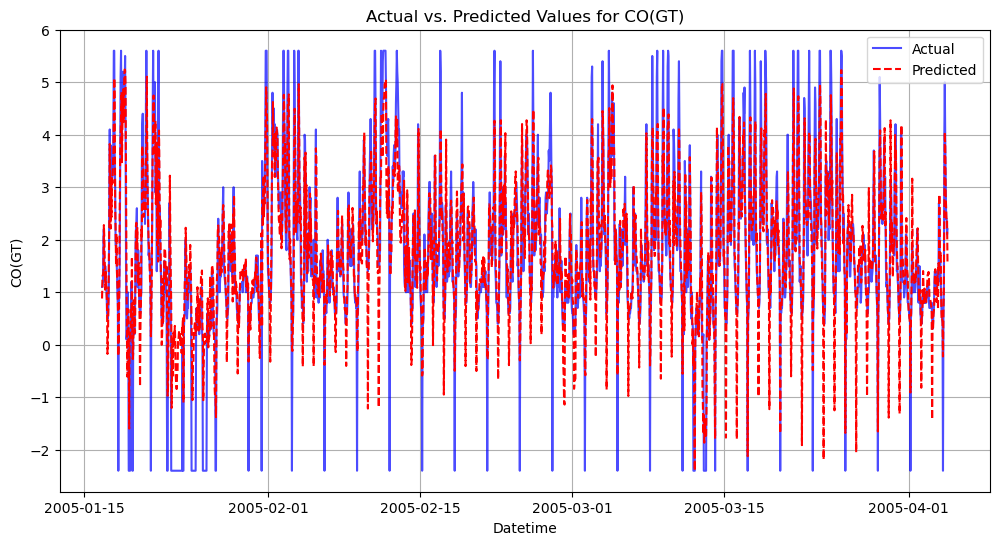

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Load and preprocess dataset
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'

try:
    data = pd.read_csv(url)
    print("Dataset Loaded Successfully!")
except Exception as e:
    print("Error loading dataset:", e)

# Combine Date and Time columns into datetime and set as index
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], errors='coerce')
data.dropna(subset=['datetime'], inplace=True)
data.set_index('datetime', inplace=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)

# Resample data to hourly intervals and handle missing values
data_resampled = data.resample('H').mean()
data_interpolated = data_resampled.interpolate(method='time')

# Outlier detection and handling
for col in ['CO(GT)', 'NO₂(GT)']:
    if col in data_interpolated.columns:
        q1 = data_interpolated[col].quantile(0.25)
        q3 = data_interpolated[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data_interpolated[col] = np.clip(data_interpolated[col], lower_bound, upper_bound)

# Rename columns for consistency
data_interpolated.rename(columns={'NO₂(GT)': 'NO2(GT)'}, inplace=True)

# Step 2: Feature Engineering
# Create lag features
for lag in range(1, 4):
    data_interpolated[f'CO(GT)_lag_{lag}'] = data_interpolated['CO(GT)'].shift(lag)

# Add time-based features
data_interpolated['hour'] = data_interpolated.index.hour
data_interpolated['day_of_week'] = data_interpolated.index.dayofweek
data_interpolated['month'] = data_interpolated.index.month

# Drop rows with NaN values caused by lagging
data_interpolated.dropna(inplace=True)

# Step 3: Prepare data for regression
X = data_interpolated[['T', 'RH', 'AH', 'hour', 'day_of_week', 'month', 'CO(GT)_lag_1', 'CO(GT)_lag_2', 'CO(GT)_lag_3']]
y = data_interpolated['CO(GT)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)

# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print Evaluation Metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs. Predicted Values for CO(GT)')
plt.xlabel('Datetime')
plt.ylabel('CO(GT)')
plt.legend()
plt.grid()
plt.show()


### 6. Visualization and Insights
- Generate forecasts for future dates and visualize the trends.
- Highlight seasonal patterns, peak times, and periods of concern.
- Provide actionable recommendations based on predicted trends.



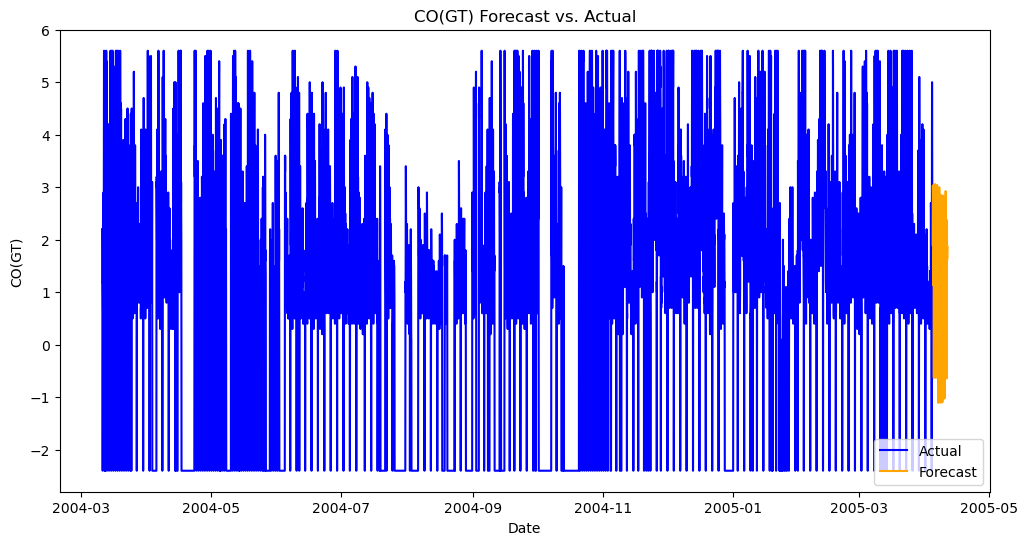

In [23]:
# Extend the dataset to include future timestamps
future_steps = 24 * 7  # Forecast for 1 week (24 hours * 7 days)
last_index = data_interpolated.index[-1]
future_dates = pd.date_range(start=last_index, periods=future_steps + 1, freq='h')[1:]  # Use 'h' instead of 'H'

# Prepare a DataFrame for future forecasts
future_data = pd.DataFrame(index=future_dates)
future_data['hour'] = future_data.index.hour
future_data['day_of_week'] = future_data.index.dayofweek
future_data['month'] = future_data.index.month

# Add the required lag features
for lag in range(1, 4):
    future_data[f'CO(GT)_lag_{lag}'] = data_interpolated['CO(GT)'].iloc[-lag]

# Add other required features with default values (or infer from historical data)
future_data['AH'] = data_interpolated['AH'].iloc[-1]  # Example: using the last known value
future_data['RH'] = data_interpolated['RH'].iloc[-1]
future_data['T'] = data_interpolated['T'].iloc[-1]

# Ensure the feature set matches the model's feature names
expected_features = rf_model.feature_names_in_  # Get the expected feature names from the trained model
future_X = future_data[expected_features]  # Use only the expected features in the correct order

# Predict future values using the trained model
future_predictions = rf_model.predict(future_X)

# Append predictions to the future data
future_data['CO(GT)_forecast'] = future_predictions

# Combine historical and future data for visualization
combined_data = pd.concat([data_interpolated[['CO(GT)']], future_data[['CO(GT)_forecast']]], axis=0)

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['CO(GT)'], label='Actual', color='blue')
plt.plot(combined_data.index, combined_data['CO(GT)_forecast'], label='Forecast', color='orange')
plt.title('CO(GT) Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('CO(GT)')
plt.legend()
plt.show()
